Logistic Regression - Predicting the outcome of a shot given its features

In [1]:

import pandas as pd
import requests
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"


In [3]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]

        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)

    return pd.DataFrame(all_events)

The `parse_data` function has been adjusted such that only shots are collected, and a bunch of new attributes are collected, including:
- `x` - the x-coordinate of the shot
    - ranges from `0 to 120`
- `y` - the y-coordinate of the shot
    - ranges from `0 to 80`
- `head` - if the shot was attempted with the head
- `phase` - what phase of play did the shot come from
- `outcome` - did the shot result in a goal
- `statsbomb_xg` - for comparison purposes at the end of the notebook

---

In [4]:
competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

100%|██████████| 64/64 [01:43<00:00,  1.62s/it]


In [5]:
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))

The `distance_to_goal` function takes an x/y pair (e.g. `[x, y]`), and calculates how far from the center of the goal that location is.

---

In [6]:
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1

    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))

    return angle

In [7]:
df['distance_to_goal'] = df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
df['goal_angle'] = df.apply(lambda r: goal_angle(r[['x', 'y']]), axis=1)

In [8]:
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]


In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
features = shots[['distance_to_goal', 'goal_angle', 'head']]
labels = shots['outcome']

fit = model.fit(features, labels)
predictions = model.predict_proba(features)[:, 1]

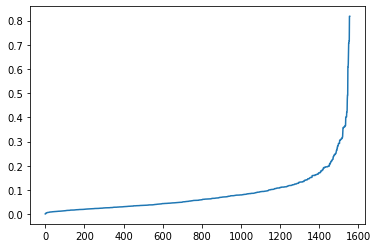

In [10]:
plt.plot(sorted(predictions))
plt.show()
